# Problem 1 - iLQR

cost: 521.7550000000007
cost: 93.06309625832469
cost: 93.02728748358132
cost: 93.02643757491482
Converged to cost 93.02643757491482


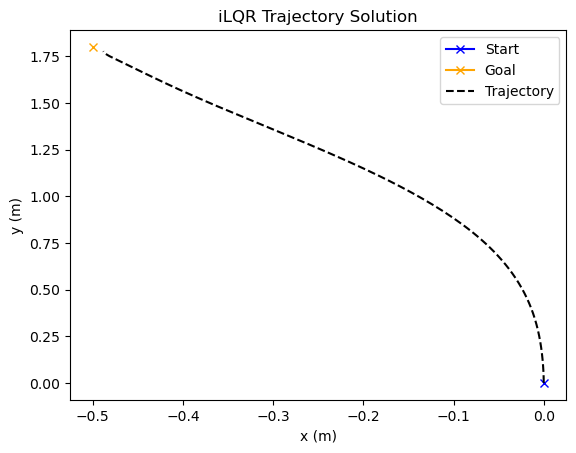

In [1]:
import numpy as np
import importlib
import iLQR
importlib.reload(iLQR)
from iLQR import iLQR

import matplotlib.pyplot as plt


# Setup the iLQR problem
N = 200
dt = 0.02
x_goal = np.array([-0.5, 1.8, 0, 0, 0, 0])

# TODO: Adjust the costs as needed for convergence
Q = np.eye(6)
Qf = 1e2 * np.eye(6)
R = 1e-3 * np.eye(2)

ilqr = iLQR(x_goal, N, dt, Q, R, Qf)

# Initial state at rest at the origin
x0 = np.zeros((6,))

# initial guess for the input is just hovering in place
u_guess = [0.5 * 9.81 * ilqr.m * np.ones((2,))] * (N-1) 

x_sol, u_sol, K_sol = ilqr.calculate_optimal_trajectory(x0, u_guess)

# Visualize the solution
xx = np.array(x_sol)
plt.plot(x0[0], x0[1], marker='x', color='blue')
plt.plot(x_goal[0], x_goal[1], marker='x', color='orange')
plt.plot(xx[:,0], xx[:,1], linestyle='--', color='black')
plt.title('iLQR Trajectory Solution')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.legend(['Start', 'Goal', 'Trajectory'])


# Problem 4 - Trajectory Optimization for a planar arm

## Start meshcat visualizer

Open the visualizer by clicking on the url in the output of this cell.

In [2]:
from pydrake.all import FindResourceOrThrow, StartMeshcat, MeshcatVisualizer
meshcat = StartMeshcat()


INFO:drake:Meshcat listening for connections at http://localhost:7001


## Compute the end effector (the ball) position and velocity using symbolic variables

This is how we get the expression in `kinematic_constraints.py`

In [3]:
# Computes the end effector velocity as xdot, ydot J_q (pos) * qdot

from sympy import *
import numpy as np

l, q0, q1, qdot0, qdot1 = symbols('l q0 q1 qdot0 qdot1', real=True)
pos = l * Matrix([-sin(q0), -cos(q0)]) + \
      l * Matrix([-sin(q0 + q1), -cos(q0 + q1)])
vel = Matrix(pos).jacobian([q0, q1]) @ np.reshape(np.array([qdot0, qdot1]), (2,1))

print('pos (x_ball, z_ball):\n', pos)
print('')
print('vel (x_ball dot, z_ball dot):\n', vel)

pos (x_ball, z_ball):
 Matrix([[-l*sin(q0) - l*sin(q0 + q1)], [-l*cos(q0) - l*cos(q0 + q1)]])

vel (x_ball dot, z_ball dot):
 Matrix([[-l*qdot1*cos(q0 + q1) + qdot0*(-l*cos(q0) - l*cos(q0 + q1))], [l*qdot1*sin(q0 + q1) + qdot0*(l*sin(q0) + l*sin(q0 + q1))]])


## Run trajectory optimization to find the optimal trajectory

In [6]:
%tb
import importlib
import find_throwing_trajectory
importlib.reload(find_throwing_trajectory)
from find_throwing_trajectory import find_throwing_trajectory

N = 5
initial_state = np.zeros(7)
final_configuration = np.array([np.pi, 0])
tf = 3.0
distance = 15.0
x_traj, u_traj, prog, _, _ = find_throwing_trajectory(N, initial_state, final_configuration, distance, tf)

SystemExit: Failure at solvers/create_constraint.cc:534 in DoParseLinearEqualityConstraint(): condition 'v.rows() == b.rows()' failed.

SystemExit: Failure at solvers/create_constraint.cc:534 in DoParseLinearEqualityConstraint(): condition 'v.rows() == b.rows()' failed.

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3386: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Visualize the optimal trajectory

This will animate the optimal trajectory in the meshcat window (see above)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time

from pydrake.all import (
    DiagramBuilder, Simulator, FindResourceOrThrow, MultibodyPlant, PiecewisePolynomial, SceneGraph,
    Parser, MultibodyPositionToGeometryPose, TrajectorySource, Demultiplexer, ConstantVectorSource
)


# Create a MultibodyPlant for the arm
file_name = "planar_arm.urdf"
builder = DiagramBuilder()
scene_graph = builder.AddSystem(SceneGraph())
planar_arm = builder.AddSystem(MultibodyPlant(0.0))
planar_arm.RegisterAsSourceForSceneGraph(scene_graph)
Parser(plant=planar_arm).AddModels(file_name)
planar_arm.Finalize()

n_q = planar_arm.num_positions()
n_v = planar_arm.num_velocities()
n_u = planar_arm.num_actuators()


x_traj_source = builder.AddSystem(TrajectorySource(x_traj))
u_traj_source = builder.AddSystem(TrajectorySource(u_traj))

demux = builder.AddSystem(Demultiplexer(np.array([n_q, n_v])))
to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(planar_arm))
zero_inputs = builder.AddSystem(ConstantVectorSource(np.zeros(n_u)))

builder.Connect(zero_inputs.get_output_port(), planar_arm.get_actuation_input_port())
builder.Connect(x_traj_source.get_output_port(), demux.get_input_port())
builder.Connect(demux.get_output_port(0), to_pose.get_input_port())
builder.Connect(to_pose.get_output_port(), scene_graph.get_source_pose_port(planar_arm.get_source_id()))

MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

diagram = builder.Build()
diagram.set_name("diagram")


# Visualize the motion for `n_playback` times
n_playback = 3
for i in range(n_playback):
  # Set up a simulator to run this diagram.
  simulator = Simulator(diagram)
  simulator.Initialize()
  simulator.set_target_realtime_rate(1)
  simulator.AdvanceTo(tf);
  time.sleep(2)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=71c969e2-d88b-4bfd-96cb-c4ea4f7f9122' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>